<a href="https://www.kaggle.com/code/danielagudeydoe/request-oriented-sampling-method?scriptVersionId=167640936" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Request-Oriented Sampling Method for DoW Attack Detection

The Request-Oriented Sampling Method is a technique used to detect denial-of-service (DoS) attacks by monitoring incoming requests to a system and analyzing various metrics associated with them. This method focuses on identifying anomalies in request patterns that may indicate a DoW attack.

## Model Description

The model used for DoW attack detection is based on a combination of function-metric coordination features and hardware metrics. It employs a neural network architecture consisting of fully connected layers to predict whether incoming requests are part of a DoS attack or not. The model is trained using historical data on request metrics and hardware characteristics, and it aims to distinguish between normal traffic patterns and suspicious activity indicative of a DoW attack.

The architecture of the model includes input layers for function-metric coordination features and hardware metrics, followed by fully connected layers for feature extraction and a final output layer for classification. The model is trained using binary cross-entropy loss and optimized using the Adam optimizer.

Once trained, the model is evaluated using test data and various performance metrics such as accuracy, precision, and receiver operating characteristic (ROC) curve analysis. Additionally, the model's inference time and performance overhead are measured to assess its efficiency and effectiveness in real-world deployment.


In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Input, Concatenate
from keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

2024-03-18 12:48:14.125880: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-18 12:48:14.125988: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-18 12:48:14.325201: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Load Dataset
- The dataset contains network traffic data, which is crucial for detecting potential Denial of Wallet (DoW) attacks.

In [2]:
# Load dataset
df = pd.read_csv('/kaggle/input/network-traffic-for-dos-detection/dataset.csv')

### Encode Categorical Variables
- Categorical variables like 'vmcategory' are encoded into numerical labels using `LabelEncoder`. This conversion is necessary as machine learning models require numerical inputs.


In [3]:
# Convert categorical variables to numerical labels
label_encoder = LabelEncoder()
df['vmcategory'] = label_encoder.fit_transform(df['vmcategory'])

In [4]:
# Define relevant features
selected_features = ['RTT', 'InvocationDelay', 'ResponseDelay', 'FunctionDuration', 'ActiveFunctionsAtRequest', 
                     'ActiveFunctionsAtResponse', 'maxcpu', 'avgcpu', 'p95maxcpu', 'vmcorecountbucket', 'vmmemorybucket']

### Normalize Features
- Features such as 'RTT', 'InvocationDelay', etc., are normalized using `MinMaxScaler`. Normalization ensures that all features have a similar scale, preventing some features from dominating others during model training.

In [5]:
# Normalize selected features
scaler = MinMaxScaler()
df[selected_features] = scaler.fit_transform(df[selected_features])

### Define Function-Metric Coordination Features
- High-level function features (e.g., request/response delays) and low-level hardware metric features (e.g., CPU usage) are identified. These features collectively capture the behavior of network functions and system resources.

In [6]:
# Define function-metric coordination features
function_metric_features = ['RTT', 'InvocationDelay', 'ResponseDelay', 'FunctionDuration', 
                            'ActiveFunctionsAtRequest', 'ActiveFunctionsAtResponse']

### Concatenate Function and Metric Features
- Function features and hardware metric features are concatenated into a single input array. This integration allows the model to learn the relationship between application-level behavior and underlying system metrics, enhancing its predictive capability.

In [7]:
# Concatenate function and metric features
X_function_metric = df[function_metric_features].values
X_hardware_metrics = df[['maxcpu', 'avgcpu', 'p95maxcpu', 'vmcorecountbucket', 'vmmemorybucket']].values

In [8]:
# Define input layers for function and hardware metrics
input_function_metric = Input(shape=(X_function_metric.shape[1],))
input_hardware_metrics = Input(shape=(X_hardware_metrics.shape[1],))

In [9]:
# Concatenate inputs
merged_inputs = Concatenate()([input_function_metric, input_hardware_metrics])

### Define Model Architecture
- A neural network model is chosen for its ability to capture complex patterns in the data.
- The model architecture consists of input layers for function and hardware metrics, followed by fully connected layers with ReLU activation.
- ReLU activation helps introduce non-linearity, enabling the model to learn complex relationships between features.
- The output layer with sigmoid activation predicts the probability of a DoW attack, as it outputs values between 0 and 1.


### Model Description

The model architecture consists of two branches, each handling different types of input data. It utilizes Keras's Functional API to create a custom neural network architecture.

### Input Layers

- **Function Metric Input**: This branch takes input data related to function metrics.
- **Hardware Metric Input**: This branch takes input data related to hardware metrics.

### Shared Layers

The model includes shared layers to extract features from both types of input data simultaneously.

### Output Layer

The output layer predicts the binary label indicating whether a sample belongs to a bot or not.

### Training

The model is trained using a specified loss function and optimizer, and the training process involves optimizing the model's parameters to minimize the loss on the training data.



In [10]:
# Define fully connected layers
dense_layer_1 = Dense(64, activation='relu')(merged_inputs)
dense_layer_2 = Dense(32, activation='relu')(dense_layer_1)

# Output layer
output_layer = Dense(1, activation='sigmoid')(dense_layer_2)

# Define model
model = Model(inputs=[input_function_metric, input_hardware_metrics], outputs=output_layer)

### Compile Model
- The model is compiled with binary crossentropy loss and Adam optimizer. Binary crossentropy is suitable for binary classification problems like DoW detection, while Adam optimizer efficiently updates model weights during training.

In [11]:
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

### Prepare Data for Training
- The dataset is split into training and testing sets using `train_test_split`. This ensures that the model's performance is evaluated on unseen data, providing a more reliable assessment of its generalization capability.

In [12]:
from sklearn.model_selection import train_test_split

# Split data into training (70%) and testing (30%)
X_function_metric_train, X_function_metric_test, X_hardware_metrics_train, X_hardware_metrics_test, y_train, y_test = train_test_split(
    X_function_metric, X_hardware_metrics, df['bot'].values, test_size=0.3, random_state=42)

# Print percentages and corresponding amounts
print("Training set size:", len(X_function_metric_train), "samples, {:.2%} of total data".format(len(X_function_metric_train) / len(df)))
print("Testing set size:", len(X_function_metric_test), "samples, {:.2%} of total data".format(len(X_function_metric_test) / len(df)))


Training set size: 130960 samples, 70.00% of total data
Testing set size: 56127 samples, 30.00% of total data


### Train Model
- The model is trained on the training data for 10 epochs with a batch size of 32. Training involves adjusting model weights to minimize the difference between predicted and actual labels, thereby improving model accuracy.

In [19]:
# Train model
history = model.fit([X_function_metric_train, X_hardware_metrics_train], y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
3274/3274 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.6973 - loss: 0.5455 - val_accuracy: 0.6967 - val_loss: 0.5414
Epoch 2/10
3274/3274 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.6987 - loss: 0.5449 - val_accuracy: 0.6967 - val_loss: 0.5410
Epoch 3/10
3274/3274 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.6999 - loss: 0.5439 - val_accuracy: 0.6967 - val_loss: 0.5412
Epoch 4/10
3274/3274 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7010 - loss: 0.5434 - val_accuracy: 0.6967 - val_loss: 0.5406
Epoch 5/10
3274/3274 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.7031 - loss: 0.5425 - val_accuracy: 0.6967 - val_loss: 0.5406
Epoch 6/10
3274/3274 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.7024 - loss: 0.5432 - val_accuracy: 0.6967 - val_loss: 0.5409
Epoch 7/10
3274/3274 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7016 - loss: 0.5439 - val_accuracy: 0.6967 - val_loss: 0.5408
Epoch 8/10
3274/3274 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.6983 - loss: 0.5458 

### Evaluate Model
- The trained model is evaluated on the testing data to assess its performance in a real-world scenario. Evaluation metrics such as test loss and accuracy provide insights into the model's effectiveness.

In [20]:
# Evaluate model on test set
test_loss, test_accuracy = model.evaluate([X_function_metric_test, X_hardware_metrics_test], y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


1754/1754 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7023 - loss: 0.5419
Test Loss: 0.5422254800796509
Test Accuracy: 0.7021041512489319


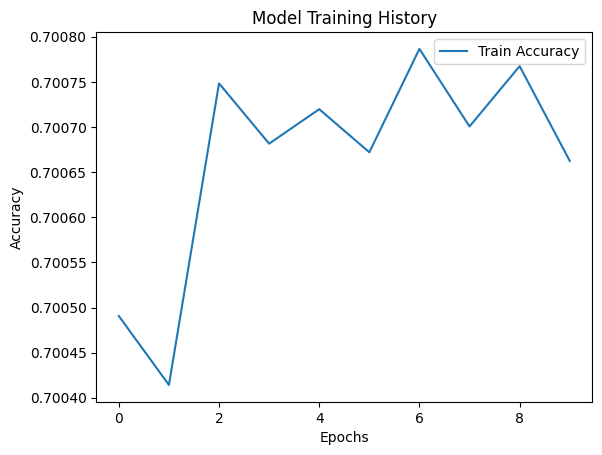

In [36]:
# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Training History')
plt.legend()
plt.show()

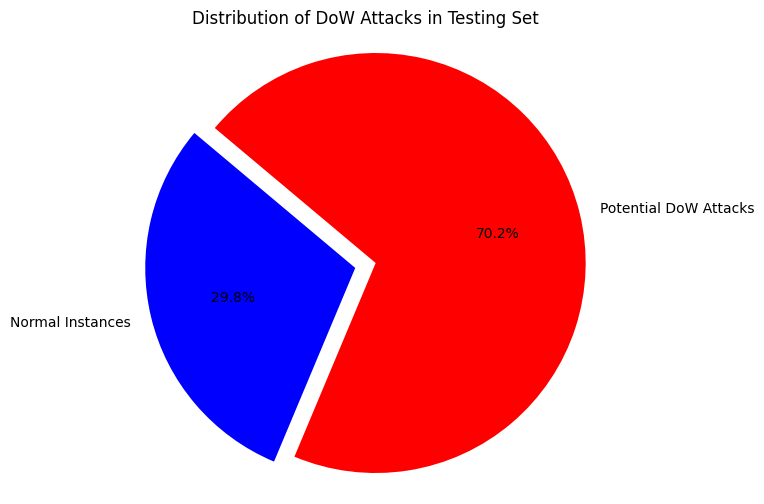

In [21]:
import matplotlib.pyplot as plt

# Calculate the percentage of DoW attacks based on the testing set
total_instances_test = len(y_test)
dos_percentage_test = np.sum(y_test) / total_instances_test * 100
normal_percentage_test = 100 - dos_percentage_test

# Pie chart for the distribution of DoW attacks in the testing set
labels = ['Normal Instances', 'Potential DoW Attacks']
sizes = [normal_percentage_test, dos_percentage_test]
colors = ['blue', 'red']  # Using a contrasting color for DoS attacks
explode = (0, 0.1)  # Explode the 2nd slice (i.e., 'Potential DoS Attacks')

plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of DoW Attacks in Testing Set')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

### Predict Probabilities
- Probabilities of DoS attacks are predicted for the test set. Predicted probabilities allow for a more nuanced understanding of model confidence in its predictions.

### Predict Binary Labels
- Binary labels (0 or 1) are predicted based on a probability threshold of 0.5. This threshold determines whether a sample is classified as a DoS attack or not.

In [22]:
# Predict probabilities for test set
y_pred_probs = model.predict([X_function_metric_test, X_hardware_metrics_test])

# Predict binary labels based on probability threshold
y_pred = (y_pred_probs > 0.5).astype(int)

1754/1754 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


### Calculate Confusion Matrix
- Confusion matrix is calculated to evaluate model performance. It provides a detailed breakdown of true positive, true negative, false positive, and false negative predictions, offering insights into model errors.

### Calculate Accuracy and Precision
- Accuracy measures the proportion of correctly classified samples, while precision measures the proportion of true positive predictions among all positive predictions. These metrics quantify the model's ability to make correct predictions and minimize false positives.

### Calculate ROC Curve
- Receiver Operating Characteristic (ROC) curve and Area Under Curve (AUC) are calculated to evaluate model performance across different probability thresholds. ROC curve illustrates the trade-off between true positive rate and false positive rate, while AUC summarizes overall model performance.

### Plot ROC Curve
- ROC curve is plotted to visualize the model's performance. A higher AUC indicates better model discrimination ability, with values closer to 1 indicating superior performance.

### Plot Confusion Matrix
- Confusion matrix is plotted to visually inspect model predictions against actual labels. This visualization aids in understanding model errors and identifying areas for improvement.

### Plot Detection of False Positives and True Positives
- Predicted probabilities and binary labels are visualized to identify false positives and true positives. This analysis helps stakeholders understand the model's behavior in distinguishing between normal network traffic and potential DoS attacks.

Accuracy: 0.7021041566447521
Precision: 0.7021041566447521
ROC AUC: 0.6900602197615535


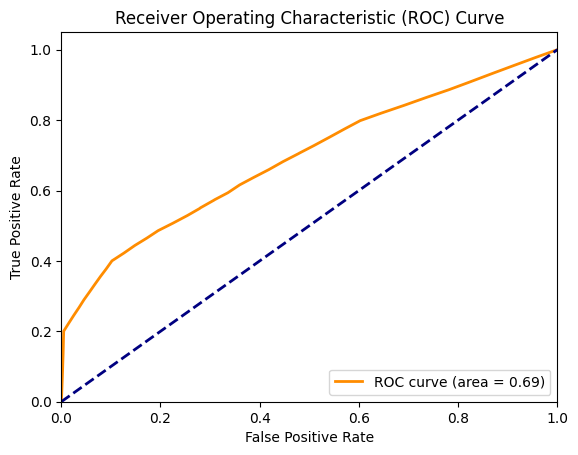

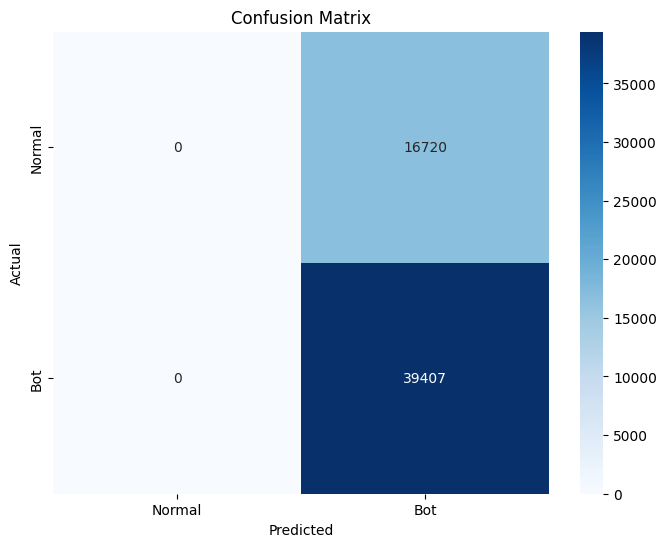

In [26]:
# Calculate accuracy and precision
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Precision:", precision)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)
print("ROC AUC:", roc_auc)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
#plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=True)
#plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['Normal', 'Bot'])
plt.yticks([0.5, 1.5], ['Normal', 'Bot'])
plt.show()


In [35]:
import time

# Make predictions on the testing set and measure time
start_time = time.time()
y_pred = model.predict([X_function_metric_test, X_hardware_metrics_test])
end_time = time.time()

# Calculate overhead and delay
overhead = end_time - start_time  # Overhead: Time taken by the model to make predictions
overhead_percentage = (overhead / start_time) * 100  # Overhead as a percentage
delay = overhead / len([X_function_metric_test, X_hardware_metrics_test])    # Delay: Average time taken per data point for prediction

# Print overhead and delay
print("Overhead (Time taken by the model to make predictions): {:.5f} seconds".format(overhead))
print("Overhead Percentage: {}%".format(overhead_percentage))
print("Delay (Average time taken per data point for prediction):{:.5f} seconds".format(delay))


1754/1754 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Overhead (Time taken by the model to make predictions): 2.99723 seconds
Overhead Percentage: 1.7519801341541947e-07%
Delay (Average time taken per data point for prediction):1.49862 seconds
